In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# IMPORTING LIBRARIES

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import datetime

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# READING FILES

In [3]:
image_files = []
image_masks = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in image_masks:
    image_files.append(i.replace('_mask',''))

display(image_files[:1])
display(image_masks[:1])

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif']

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif']

# SHOWING FILES

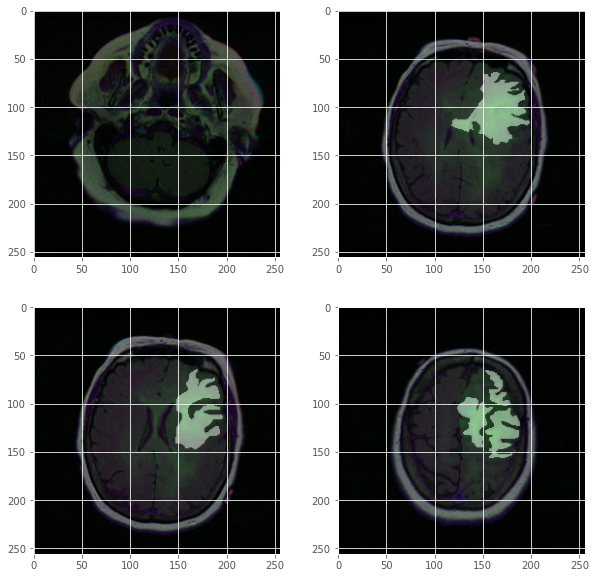

In [4]:
def show_images_masks(rows : int = 3, columns : int = 3):
    
    fig = plt.figure(figsize = (10, 10))

    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = image_files[i]
        msk_path = image_masks[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        msk = cv2.imread(msk_path)
        plt.imshow(img)
        plt.imshow(msk, alpha = 0.4)
    
    plt.show()


show_images_masks(rows = 2, columns = 2) # overwrite to see more images

In [5]:
def split_train_test():

    mri = pd.DataFrame(data = {"filename" : image_files, 
                                "mask"    : image_masks}
                       )
    
    train, test       = train_test_split(mri, test_size = 0.1)
    train, validation = train_test_split(train, test_size = 0.2)
    
    return train, test, validation

train, validation, test = split_train_test()

display(train.values.shape)
display(test.values.shape)
display(validation.values.shape)

(2828, 2)

(708, 2)

(393, 2)

# DATA PIPELINE GENERATION

In [6]:
def train_generator(data_frame        : pd.DataFrame(),
                    batch_size        : int,
                    aug_dict          : dict(),
                    image_color_mode  = "rgb",
                    mask_color_mode   = "grayscale",
                    image_save_prefix = "image",
                    mask_save_prefix  = "mask",
                    save_to_dir       = None,
                    target_size       = (256, 256),
                    seed              = 1
                    ):
    
    """
    Generates image and mask at the same time use the same seed for image_datagen
    and mask_datagen
    """


    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "filename",
                                                        class_mode   = None,
                                                        color_mode   = image_color_mode,
                                                        target_size  = target_size,
                                                        batch_size   = batch_size,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed
                                                        )

    mask_generator = mask_datagen.flow_from_dataframe(
                                                        data_frame,
                                                        x_col        = "mask",
                                                        class_mode   = None,
                                                        color_mode   = mask_color_mode,
                                                        target_size  = target_size,
                                                        batch_size   = batch_size,
                                                        save_to_dir  = save_to_dir,
                                                        save_prefix  = mask_save_prefix,
                                                        seed         = seed
                                                      )

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# LOSS FUNCTION AND METRICS

In [7]:
smooth = 100

def dice_coef(y_true, y_pred):
    y_true_flattened = K.flatten(y_true)
    y_pred_flattened = K.flatten(y_pred)
    And = K.sum(y_true_flattened * y_pred_flattened)
    return((2 * And + smooth) / (K.sum(y_true_flattened) + K.sum(y_pred_flattened) + smooth))

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):

    """
    Intersection over union calculation

    """
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    """
    Jaccard's Distance Calculations
    """
    y_true_flattened = K.flatten(y_true)
    y_pred_flattened = K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [8]:

def my_filter(shape, dtype = None):

    kernel = np.zeros(shape)

    kernel[:, :, 0, 0] = np.array([[1, 0, 1], 
                                   [2, 1, 0],
                                   [0, 0, 1]])
    assert kernel.shape == shape
    return K.variable(kernel, dtype='float32')

In [9]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

# Unet MODEL DEFINATION

In [10]:
def U_Net(input_size = (256, 256, 3)):
    
    
    inputs = Input(input_size)
    convolution_block_1 = Conv2D(filters   = 64,
                   kernel_size             = (3, 3),
#                    kernel_initializer      = my_filter,
                   padding                 = 'SAME')(inputs)
    
    
    batch_norm_1        = Activation('relu')(convolution_block_1)
    convolution_block_1 = Conv2D(64, (3, 3), padding = 'SAME')(batch_norm_1)
    batch_norm_1        = BatchNormalization(axis = 3)(convolution_block_1)
    batch_norm_1        = Activation('relu')(batch_norm_1)
    pooling_1           = MaxPooling2D(pool_size = (2, 2))(batch_norm_1)


    convolution_block_2 = Conv2D(128, (3, 3), padding = 'SAME')(pooling_1)
    bath_norm_2         = Activation('relu')(convolution_block_2)
    convolution_block_2 = Conv2D(128, (3, 3), padding = 'SAME')(bath_norm_2)
    bath_norm_2         = BatchNormalization(axis=3)(convolution_block_2)
    bath_norm_2         = Activation('relu')(bath_norm_2)
    pooling_2           = MaxPooling2D(pool_size=(2, 2))(bath_norm_2)



    convolution_block_3 = Conv2D(256, (3, 3), padding = 'SAME')(pooling_2)
    batch_norm_3        = Activation('relu')(convolution_block_3)
    convolution_block_3 = Conv2D(256, (3, 3), padding = 'SAME')(batch_norm_3)
    batch_norm_3        = BatchNormalization(axis = 3)(convolution_block_3)
    batch_norm_3        = Activation('relu')(batch_norm_3)
    pooling_3           = MaxPooling2D(pool_size = (2, 2))(batch_norm_3)


    convolution_block_4 = Conv2D(512, (3, 3), padding = 'SAME')(pooling_3)
    batch_norm_4        = Activation('relu')(convolution_block_4)
    convolution_block_4 = Conv2D(512, (3, 3), padding = 'SAME')(batch_norm_4)
    batch_norm_4        = BatchNormalization(axis = 3)(convolution_block_4)
    batch_norm_4        = Activation('relu')(batch_norm_4)
    pooling_4           = MaxPooling2D(pool_size = (2, 2))(batch_norm_4)


    convolution_block_5 = Conv2D(1024, (3, 3), padding = 'SAME')(pooling_4)
    batch_norm_5        = Activation('relu')(convolution_block_5)
    convolution_block_5 = Conv2D(1024, (3, 3), padding = 'SAME')(batch_norm_5)
    batch_norm_5        = BatchNormalization(axis=3)(convolution_block_5)
    batch_norm_5        = Activation('relu')(batch_norm_5)


    up_sampling_6       = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding = 'SAME')(batch_norm_5), convolution_block_4], axis=3)
    convolution_block_6 = Conv2D(512, (3, 3), padding='same')(up_sampling_6)
    batch_norm_6        = Activation('relu')(convolution_block_6)
    convolution_block_6 = Conv2D(512, (3, 3), padding='same')(batch_norm_6)
    batch_norm_6        = BatchNormalization(axis=3)(convolution_block_6)
    batch_norm_6        = Activation('relu')(batch_norm_6)



    up_sampling_7       = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding = 'SAME')(batch_norm_6), convolution_block_3], axis=3)
    convolution_block_7 = Conv2D(256, (3, 3), padding = 'SAME')(up_sampling_7)
    batch_norm_7        = Activation('relu')(convolution_block_7)
    convolution_block_7 = Conv2D(256, (3, 3), padding = 'SAME')(batch_norm_7)
    batch_norm_7        = BatchNormalization(axis = 3)(convolution_block_7)
    batch_norm_7        = Activation('relu')(batch_norm_7)


    up_sampling_8       = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(batch_norm_7), convolution_block_2], axis=3)
    convolution_block_8 = Conv2D(128, (3, 3), padding = 'SAME')(up_sampling_8)
    batch_norm_8        = Activation('relu')(convolution_block_8)
    convolution_block_8 = Conv2D(128, (3, 3), padding = 'SAME')(batch_norm_8)
    batch_norm_8        = BatchNormalization(axis = 3)(convolution_block_8)
    batch_norm_8        = Activation('relu')(batch_norm_8)


    up_sampling_9       = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'SAME')(batch_norm_8), convolution_block_1], axis=3)
    convolution_block_9 = Conv2D(64, (3, 3), padding = 'SAME')(up_sampling_9)
    batch_norm_9        = Activation('relu')(convolution_block_9)
    convolution_block_9 = Conv2D(64, (3, 3), padding = 'SAME')(batch_norm_9)
    batch_norm_9        = BatchNormalization(axis = 3)(convolution_block_9)
    batch_norm_9        = Activation('relu')(batch_norm_9)

    convolution_block_10 = Conv2D(1, (1, 1), activation = 'sigmoid')(batch_norm_9)

    return Model(inputs = [inputs], outputs = [convolution_block_10])

In [11]:
model = U_Net()
# model.summary()

2022-10-23 22:47:38.098247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 22:47:38.253138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 22:47:38.253945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 22:47:38.255643: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
EPOCHS          = 25
BATCH_SIZE      = 32
learning_rate   = 1e-4

In [13]:
VARIABILITY = 50


def add_gaussian_noise(img):
    deviation = VARIABILITY * random.random()
    noise     = np.random.normal(0, deviation, img.shape)
    img       += noise
    
    np.clip(img, 0., 255.)
    return img

# _, noise = add_gaussian_noise("path/to/image.jpg")

# MODEL COMPILATION

In [14]:

time_stamp = datetime.datetime.now()


train_generator_args = dict(rotation_range         = 0.2,
                            width_shift_range      = 0.05,
                            height_shift_range     = 0.05,
                            shear_range            = 0.05,
                            zoom_range             = 0.05,
                            horizontal_flip        = True,
                            fill_mode              = 'nearest',
#                             preprocessing_function = add_gaussian_noise
                            )

train_gen = train_generator(train,
                            BATCH_SIZE,
                            train_generator_args,
                            target_size = (IMG_HEIGHT, IMG_WIDTH))
    
test_gener = train_generator(validation,
                             BATCH_SIZE,
                             dict(),
                             target_size = (IMG_HEIGHT, IMG_WIDTH))
    
model = U_Net(input_size=(IMG_HEIGHT, IMG_WIDTH, 3))

decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate  = learning_rate,
                  beta_1  = 0.9, 
                  beta_2  = 0.999,
                  epsilon = None,
                  decay   = decay_rate, 
                  amsgrad = False)

model.compile(optimizer = opt, 
              loss      = dice_coef_loss,
              metrics   = ["binary_accuracy", iou, dice_coef])

callbacks = ModelCheckpoint('Unet_Brain_MRI_V2.hdf5', 
                            verbose        = 1, 
                            save_best_only = True)

training_log = TensorBoard(log_dir = 'training_logs/')

2022-10-23 22:47:41.537005: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-23 22:47:41.537053: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-23 22:47:41.538902: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-23 22:47:41.769245: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-23 22:47:41.769420: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# TRAINING

In [15]:
history = model.fit(train_gen,
                    steps_per_epoch  = len(train) / BATCH_SIZE, 
                    epochs           = EPOCHS, 
                    callbacks        = [callbacks, training_log],
                    validation_data  = test_gener,
                    validation_steps = len(validation) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.


2022-10-23 22:47:45.275781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-10-23 22:47:48.212563: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/88 [..............................] - ETA: 25:15 - loss: -0.0229 - binary_accuracy: 0.9585 - iou: 0.0117 - dice_coef: 0.0229

2022-10-23 22:48:02.687149: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-23 22:48:02.687195: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/88 [..............................] - ETA: 1:32 - loss: -0.0212 - binary_accuracy: 0.9420 - iou: 0.0108 - dice_coef: 0.0212 

2022-10-23 22:48:03.712687: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-23 22:48:03.714248: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-23 22:48:03.863261: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 637 callback api events and 632 activity events. 
2022-10-23 22:48:03.886635: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-23 22:48:03.921377: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/train/plugins/profile/2022_10_23_22_48_03

2022-10-23 22:48:03.938030: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/train/plugins/profile/2022_10_23_22_48_03/29a15681ed36.trace.json.gz
2022-10-23 22:48:03.995765: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating director

89/88 [==============================] - ETA: 0s - loss: -0.1878 - binary_accuracy: 0.9604 - iou: 0.1076 - dice_coef: 0.1883Found 393 validated image filenames.
Found 393 validated image filenames.
88/88 [==============================] - 125s 1s/step - loss: -0.1878 - binary_accuracy: 0.9604 - iou: 0.1076 - dice_coef: 0.1883 - val_loss: -0.0247 - val_binary_accuracy: 0.9884 - val_iou: 0.0129 - val_dice_coef: 0.0253

Epoch 00001: val_loss improved from inf to -0.02465, saving model to Unet_Brain_MRI_V2.hdf5
Epoch 2/25
88/88 [==============================] - 82s 936ms/step - loss: -0.3232 - binary_accuracy: 0.9909 - iou: 0.1969 - dice_coef: 0.3235 - val_loss: -0.0237 - val_binary_accuracy: 0.9877 - val_iou: 0.0122 - val_dice_coef: 0.0235

Epoch 00002: val_loss did not improve from -0.02465
Epoch 3/25
88/88 [==============================] - 83s 942ms/step - loss: -0.3908 - binary_accuracy: 0.9924 - iou: 0.2480 - dice_coef: 0.3913 - val_loss: -0.0164 - val_binary_accuracy: 0.9881 - val_

# TRAINING LOSS AND ACCURACY

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fisize" which is no longer supported as of 3.3 and will become an error in 3.6


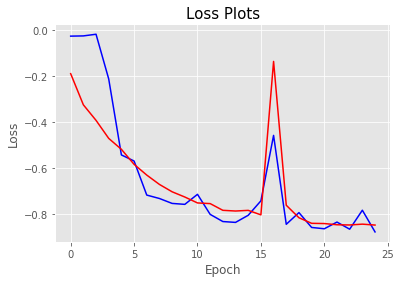

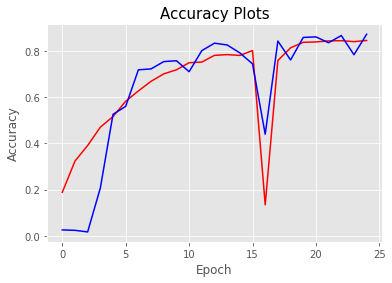

In [16]:
def plot_loss_accuracy():

    a = history.history

    list_traindice    = a['dice_coef']
    list_testdice     = a['val_dice_coef']

    list_trainjaccard = a['iou']
    list_testjaccard  = a['val_iou']

    list_trainloss    = a['loss']
    list_testloss     = a['val_loss']
    
    plt.figure(1)
    plt.plot(list_testloss, 'b-')
    plt.plot(list_trainloss,'r-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plots', fontsize = 15)
    plt.savefig("Loss Plots.jpg",figsize=(8,8))
    
    plt.figure(2)
    plt.plot(list_traindice, 'r-')
    plt.plot(list_testdice, 'b-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plots', fontsize = 15)
    plt.savefig("Accuracy Graphs.jpg",fisize=(8,8))
    plt.show()
    
plot_loss_accuracy()

In [17]:
test_gen = train_generator(test,
                           BATCH_SIZE,
                           dict(),
                           target_size = (IMG_HEIGHT, IMG_WIDTH))

results = model.evaluate(test_gen, 
                         steps = len(test) / BATCH_SIZE)

print("Test loss: ",            results[0])
print("Test IOU: ",             results[1])
print("Test Dice Coefficent: ", results[2])

Found 708 validated image filenames.
Found 708 validated image filenames.
22/22 [==============================] - 10s 459ms/step - loss: -0.8417 - binary_accuracy: 0.9973 - iou: 0.7253 - dice_coef: 0.8315
Test loss:  -0.8416683673858643
Test IOU:  0.9973140358924866
Test Dice Coefficent:  0.72530198097229


# TESTING MODEL

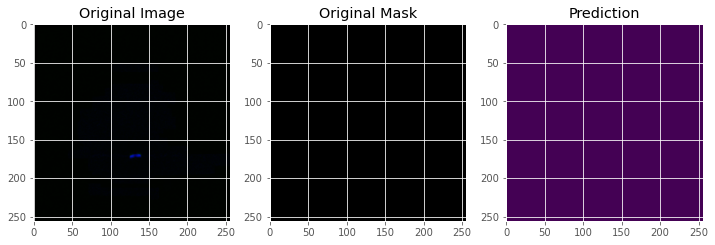

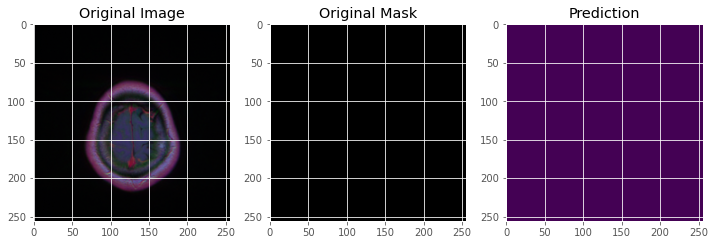

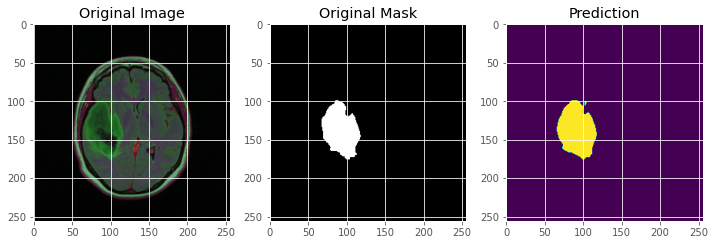

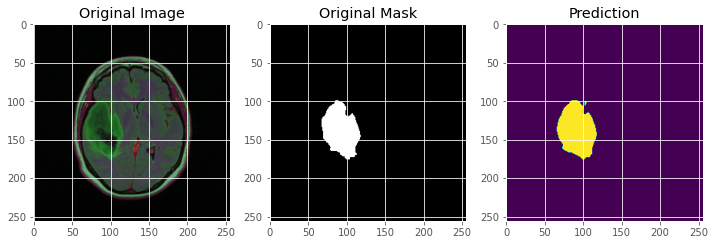

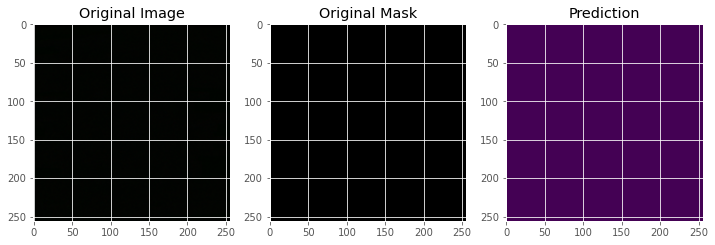

In [18]:

def plot_prediction(number_of_images : int = None):

    for i in range(number_of_images):

        index = np.random.randint(1, len(test.index))
        img = cv2.imread(test['filename'].iloc[index])
        img = cv2.resize(img,(IMG_HEIGHT, IMG_WIDTH))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred = model.predict(img)

        plt.figure(figsize = (12, 12))
        plt.subplot(1, 3 ,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(cv2.imread(test['mask'].iloc[index])))
        plt.title('Original Mask')
    
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

plot_prediction(5)

In [19]:
!wget -P /kaggle/working/test_images/ "https://www.osfhealthcare.org/blog/wp-content/uploads/2019/10/brain-tumor-ini-ft3-765x310.jpg"

--2022-10-23 23:24:26--  https://www.osfhealthcare.org/blog/wp-content/uploads/2019/10/brain-tumor-ini-ft3-765x310.jpg
Resolving www.osfhealthcare.org (www.osfhealthcare.org)... 104.130.145.245
Connecting to www.osfhealthcare.org (www.osfhealthcare.org)|104.130.145.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19827 (19K) [image/jpeg]
Saving to: ‘/kaggle/working/test_images/brain-tumor-ini-ft3-765x310.jpg’

brain-tumor-ini-ft3 100%[===================>]  19.36K  --.-KB/s    in 0s      

2022-10-23 23:24:27 (86.7 MB/s) - ‘/kaggle/working/test_images/brain-tumor-ini-ft3-765x310.jpg’ saved [19827/19827]



# TESTING FOR EXTERNAL DATA

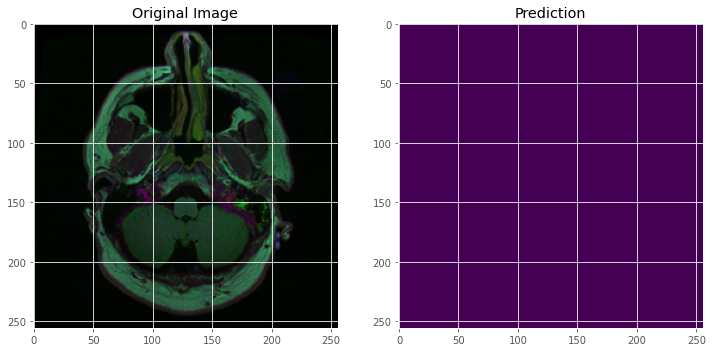

In [20]:
import matplotlib
import random
import glob
import cv2
import numpy as np
from tensorflow.keras.models import load_model

try:
    import matplotlib.pyplot as plt

except:
    pass

IMG_HEIGHT, IMG_WIDTH = 256, 256



def load_mri_model():
    return load_model('./Unet_Brain_MRI_V2.hdf5', compile = False)

PATH = '/kaggle/test_images/brain-tumor-ini-ft3-765x310.jpg'

def segment_tumor_MRI(path):
    img = cv2.imread(test['filename'].iloc[12])
    img   = cv2.resize(img ,(IMG_HEIGHT, IMG_WIDTH))
    img   = img / 255
    img   = img[np.newaxis, :, :, :]

    model = load_mri_model()
    pred  = model.predict(img)

    plt.figure(figsize = (12 ,12))
    
    plt.subplot(1, 2 ,1) 
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(pred) > 0.5, interpolation = "nearest", cmap = "viridis")
    plt.title('Prediction')
    plt.show()

test_images = glob.glob(PATH)
image_test  = random.choice(PATH)
segment_tumor_MRI(path = image_test)

## VOILA, WE GOT THE SEGMENTED IMAGE